# Zipline

Zipline is an open-source algorithmic trading simulator.

The source can be found at: https://github.com/quantopian/zipline

Some benefits include:

* Realistic: slippage, transaction costs, order delays.
* Stream-based: Process each event individually, avoids look-ahead bias.
* Batteries included: Common transforms (moving average) as well as common risk calculations (Sharpe).

In [14]:
import pandas as pd
import pandas.io.data
import numpy as np

%matplotlib inline

import pytz
from datetime import datetime

import zipline as zp
from zipline.api import symbol
from zipline.finance.slippage import FixedSlippage

## Simplest Zipline Algorithm: Buy Apple

Load Apple (AAPL) historical prices from yahoo finance.

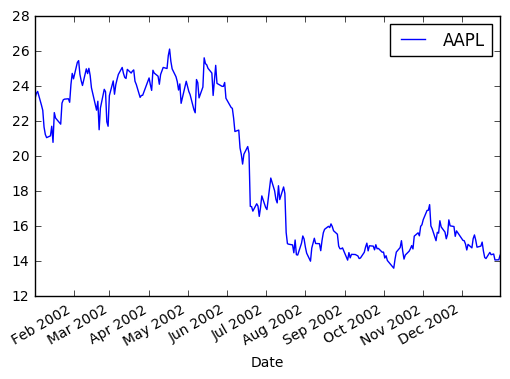

In [15]:
start = datetime(2002, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2003, 1, 1, 0, 0, 0, 0, pytz.utc)
data = zp.utils.factory.load_from_yahoo(stocks=['AAPL'], indexes={}, start=start,
                                        end=end, adjusted=False)
data.plot()

Define trading algorithm by inheriting from `zipline.TradingAlgorithm`.

We have to overwrite two methods:

* `initialize()`: Called once before the beginning of the simulation
* `handle_data(data)`: Called for every bar. Data contains only information available at this point in time.

Some commonly used attributes and methods include:

* `self.order(stock, amount)`: Order `amount` of `stock`'s shares
* `self.run(data)`: Start the simulation. `data` can be a `pandas.DataFrame` that will be streamed through the algorithm and accessed there. It returns a `DataFrame` containing performance information of our algorithm.

In [16]:
class BuyApple(zp.TradingAlgorithm): # inherit from TradingAlgorithm
    def handle_data(self, data): # overload handle_data() method
        self.order(symbol('AAPL'), 1) # stock (='AAPL') to order and amount (=1 shares)

Instantiate class and call the `.run()` method to start the backtest.

In [17]:
algo = BuyApple()
perf = algo.run(data)

In [19]:
perf.head()
# we have like 38 columns here, Which one are important to consider?

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2002-01-02 21:00:00,NaN,0.000000,NaN,0.005740,NaN,NaN,0.000000,100000.000000,0.000000,0.000000,...,0,0,0,NaN,100000.000000,0.000000,0.000000,1,[],0.0520
2002-01-03 21:00:00,0.000112,-0.000010,0.004205,0.014973,0.038614,-0.002907,-24.580001,99975.419999,23.580001,23.580001,...,0,0,0,-11.224972,100000.000000,0.000000,0.000000,2,"[{u'commission': None, u'amount': 1, u'sid': E...",0.0516
2002-01-04 21:00:00,0.000087,-0.000019,0.001976,0.021279,0.029599,-0.002007,-24.690000,99950.729999,47.380000,47.380000,...,0,0,0,-12.939589,99975.419999,23.580001,23.580001,3,"[{u'commission': None, u'amount': 1, u'sid': E...",0.0518
2002-01-07 21:00:00,0.000170,-0.000045,-0.003991,0.014642,0.110180,0.001274,-23.900000,99926.829999,68.700000,68.700000,...,0,0,0,-12.206377,99950.729999,47.380000,47.380000,4,"[{u'commission': None, u'amount': 1, u'sid': E...",0.0509
2002-01-08 21:00:00,0.000157,-0.000063,-0.003875,0.011001,0.108405,0.001221,-23.610000,99903.219999,90.440000,90.440000,...,0,0,0,-13.022769,99926.829999,68.700000,68.700000,5,"[{u'commission': None, u'amount': 1, u'sid': E...",0.0510


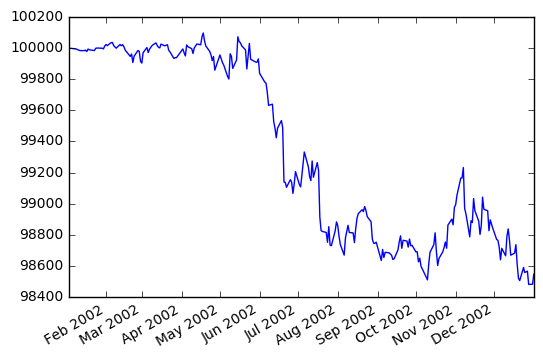

In [20]:
perf.portfolio_value.plot()

Common Algo Trading Strategies
==============================

Broadly, algorithmic trading strategies come in two flavors:

* Momentum Strategy: Stocks have momentum (i.e. upward or downward trends) that we can detect and exploit.
* Mean-reversion Strategy: Stocks return to their mean and we can exploit when it deviates from that mean.

Classic Momentum Strategy: Dual Moving Average Cross-Over
---------------------------------------------------------

In [21]:
class DualMovingAverage(zp.TradingAlgorithm):
    """Dual Moving Average Crossover algorithm.

    This algorithm buys apple once its short moving average crosses
    its long moving average (indicating upwards momentum) and sells
    its shares once the averages cross again (indicating downwards
    momentum).

    """
    def initialize(self, short_window=100, long_window=400):
        # Add 2 mavg transforms, one with a long window, one
        # with a short window.
        self.add_transform(zp.transforms.MovingAverage, 'short_mavg', ['price'],
                           window_length=short_window)

        self.add_transform(zp.transforms.MovingAverage, 'long_mavg', ['price'],
                           window_length=long_window)

        # To keep track of whether we invested in the stock or not
        self.invested = False

    def handle_data(self, data):
        short_mavg = data['AAPL'].short_mavg['price']
        long_mavg = data['AAPL'].long_mavg['price']
        buy = False
        sell = False

        if short_mavg > long_mavg and not self.invested:
            self.order('AAPL', 100)
            self.invested = True
            buy = True
        elif short_mavg < long_mavg and self.invested:
            self.order('AAPL', -100)
            self.invested = False
            sell = True

        self.record(short_mavg=short_mavg,
                    long_mavg=long_mavg,
                    buy=buy,
                    sell=sell)

In [22]:
dma = DualMovingAverage()
perf = dma.run(data)

AttributeError: 'DualMovingAverage' object has no attribute 'add_transform'

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211,  ylabel='Price in $')
data['AAPL'].plot(ax=ax1, color='r', lw=2.)
perf[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

ax1.plot(perf.ix[perf.buy].index, perf.short_mavg[perf.buy],
         '^', markersize=10, color='m')
ax1.plot(perf.ix[perf.sell].index, perf.short_mavg[perf.sell],
         'v', markersize=10, color='k')

ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
perf.portfolio_value.plot(ax=ax2, lw=2.)

ax2.plot(perf.ix[perf.buy].index, perf.portfolio_value[perf.buy],
         '^', markersize=10, color='m')
ax2.plot(perf.ix[perf.sell].index, perf.portfolio_value[perf.sell],
         'v', markersize=10, color='k')

plt.legend(loc=0)
plt.gcf().set_size_inches(14, 10)

Mean-reversion strategies
-------------------------

Idea: If stock (or combination of stocks as in pairtrading) always revert back to its mean, we can long (short) the stock if it decreases (increases) from its mean.

Load stocks that are correlated (and hopefully cointegrated, which means that a linear combination of them will be mean-reverting).

Coca-Cola (KO) and Pepsi (PEP) is a good example as they are both in the same market segment and are both likely to be affected by the same events (e.g. increase of price of corn syrup).

In [ ]:
start = datetime(1997, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(1998, 6, 1, 0, 0, 0, 0, pytz.utc)
data = zp.utils.factory.load_from_yahoo(stocks=['PEP', 'KO'], indexes={},
                                        start=start, end=end, adjusted=True)

The idea is that while neither stock price is mean-reverting, a linear combination of them will be.

In [ ]:
data[['PEP', 'KO']].plot()
plt.ylabel('price')

plt.figure()
integrated = data.PEP - data.KO
integrated.plot()
plt.ylabel('combined price')
plt.axhline(integrated.mean())

In [ ]:
plt.plot(data.PEP, data.KO, 'x')
plt.xlabel('PEP')
plt.ylabel('KO')

Normally, we'd run a statistical test for cointegration like the [Dickey-Fuller test](http://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) but we'll skip this here.

Idea of the strategy
--------------------
Now, we can exploit this mean-reversion property of the integrated series as follows: Assume that PEP and KO drift apart, as they do Nov 1997. If we assume that they are mean-reverting we expect this gap to close again as the stocks prices come back together (which they do by Jan 1998). In other words, during this time where the spread is large, we think that PEP is overvalued, while KO is undervalued. We thus short PEP with the expectation that it will go down, and long KO under the expectation that it will go up.

Estimating the regression coefficients
--------------------------------------
In this particular example it seems we can just subtract them but in reality it might be that the correlation is not 1. In our algorithm we thus estimate the regression between them in order to create a mean-reverting series using `scipy.stats.linregress(price1, price2)`.

BatchTransform
--------------
However, Zipline is designed in such a way that we ever only have access to the current price. We thus need a window of past events. The `batch_transform` gives us this functionality. It is a decorator for a function which will, behind the scenes, aggregate the data and pass a `pandas` `Panel` (a 3D `DataFrame`) into our a function.

In [ ]:
# Warning: This algorithm is written to illustrate the core idea of pairtrading. 
# In reality, however, there are many more details we have to consider to make
# this actually work.

from zipline.transforms import batch_transform
from scipy import stats

@batch_transform
def regression_transform(data):
    """Computes regression coefficient (slope and intercept)
    via Ordinary Least Squares between two SIDs.
    """
    # data is now an array containg all past events up until now
    pep_price = data.price['PEP']
    ko_price = data.price['KO']
    slope, intercept, _, _, _ = stats.linregress(pep_price, ko_price)

    return intercept, slope


class Pairtrade(zp.TradingAlgorithm):
    """Pairtrading relies on cointegration of two stocks.

    The expectation is that once the two stocks drifted apart
    (i.e. there is spread), they will eventually revert again. Thus,
    if we short the upward drifting stock and long the downward
    drifting stock (in short, we buy the spread) once the spread
    widened we can sell the spread with profit once they converged
    again. A nice property of this algorithm is that we enter the
    market in a neutral position.

    This specific algorithm tries to exploit the cointegration of
    Pepsi and Coca Cola by estimating the correlation between the
    two. Divergence of the spread is evaluated by z-scoring.
    """

    def initialize(self, window_length=100):
        self.set_slippage(FixedSlippage())
        self.invested = False
        self.regression_transform = regression_transform(refresh_period=500,
                                                         window_length=window_length)

    def handle_data(self, data):
        # 1. Compute regression coefficients between PEP and KO
        params = self.regression_transform.handle_data(data)
        if params is None:
            self.record(buy_spread=False, sell_spread=False)
            return
        intercept, slope = params

        # 2. Compute spread
        spread = (slope * data['PEP'].price + intercept) - data['KO'].price
        
        buy_spread = False
        sell_spread = False
        # 3. Place orders
        if spread >= 5.0 and not self.invested:
            # Stocks drifted apart, long one, short the other
            self.order('KO', 100)
            self.order('PEP', -100)
            self.invested = True
            buy_spread = True
        elif spread <= 2. and self.invested:
            # The spread is closing again, exit positions.
            # ???
            # Profit!
            self.order('KO', -100)
            self.order('PEP', 100)
            self.invested = False
            sell_spread = True
        
        # Record spread for later analysis
        self.record(spread=spread,
                    buy_spread=buy_spread,
                    sell_spread=sell_spread)

In [ ]:
# Run strategy
pairtrade = Pairtrade()
results = pairtrade.run(data)

In [ ]:
ax1 = plt.subplot(311)
data[['PEP', 'KO']].plot(ax=ax1)
plt.ylabel('price')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(312, sharex=ax1)
results.spread.plot(ax=ax2, color='k')
ax2.axhline(2, color='k')
ax2.axhline(5, color='k')
plt.ylabel('spread')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(313, sharex=ax1)
results.portfolio_value.plot(ax=ax3, color='k')
plt.ylabel('portfolio value')

# Plot spread enter and exit markers
enter_pos = results.index[results.buy_spread]
exit_pos = results.index[results.sell_spread]
for ax in [ax1, ax2, ax3]:
    ax.axvline(enter_pos, c='g')
    ax.axvline(exit_pos, c='r')
plt.gcf().set_size_inches(16, 12)

## Optional: Zipline version of Google Strategy

In [ ]:
# Load Preis data
data = pd.read_csv('data/GoogleTrendsData.csv', index_col='Date', parse_dates=True)
data.index = data.index.tz_localize(pytz.UTC)
data.head()

In [ ]:
# window length of 3 as in original publication
delta_t = 3

class GoogleTrends(zp.TradingAlgorithm):
    def initialize(self):
        # Moving window. Defining maxlen causes the window length 
        # to remain constant as old events get dropped once full.
        self.window = deque(maxlen=delta_t)
        # Turns off slippage to simplify simulation.
        self.set_slippage(FixedSlippage())
    
    def handle_data(self, data):
        window_full = len(self.window) == delta_t
        
        # Extract debt search volume. 
        # 'price' is the default field used if no further information is supplied.
        debt = data['debt']['price']
        
        # Exit any prior positions
        if 'djia' in self.portfolio.positions:
            self.order('djia', -self.portfolio.positions['djia']['amount'])
            
        # Moving average cross-over logic
        if debt > np.mean(self.window) and window_full:
            self.order('djia', -100)
        elif debt < np.mean(self.window) and window_full:
            self.order('djia', 100)
        
        self.window.append(debt)